In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, Normalization, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2025-11-05 21:51:05.012332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-05 21:51:06.805960: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-05 21:51:15.034975: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Data Processing

In [46]:
IMG_HEIGHT, IMG_WIDTH = 299, 299  # match InceptionV3 input size

# Training data generator (with random flip + rotation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=10,
    validation_split=0.15
)

# Validation generator (no augmentation, just rescaling)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15
)


Found 2572 images belonging to 4 classes.
Found 451 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


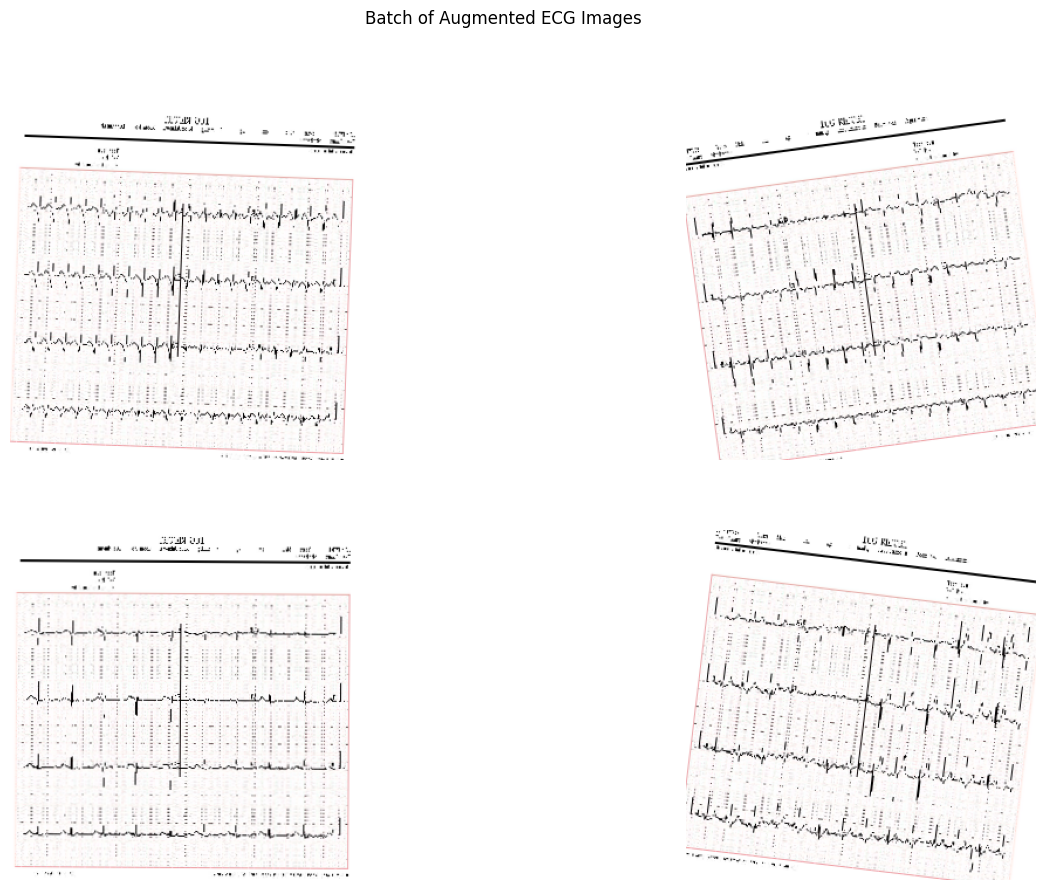

In [47]:
# Paths
train_dir = "../Data/train"
test_dir = "../Data/test"
classes = ["Abnormal_Heartbeat", "Myocardial_Infarction", "History_Myocardial_Infarction", "Normal"]

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Separate test generator
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


# Visualize a batch
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(16,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')
plt.suptitle("Batch of Augmented ECG Images")
plt.show()

# Models

In [48]:
# CNN Model
def Baseline_CNN(input_shape=(256,512,3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2,2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Conv2D(128, (3,3), activation='relu'),
        MaxPooling2D(2,2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model


def Small_1CNN(input_shape=(256, 512, 3), num_classes=4):

    model = Sequential([
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((4,4)),  # reduces feature map size drastically
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

def Small_2CNN(input_shape=(299, 299, 3), num_classes=4):
    model = Sequential([
        Conv2D(16, (3,3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((4,4)),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        MaxPooling2D((4,4)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [49]:
# Stop training if val_loss doesn't improve for 5 epochs
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Reduce LR by factor of 0.5 if val_loss doesn't improve for 3 epochs
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Save the best model as a .keras file
checkpoint = ModelCheckpoint(
    "Small_2CNN_best.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, lr_scheduler, checkpoint]

In [50]:

model = Small_2CNN()
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 74, 74, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 18, 18, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │       663,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 668,964 (2.55 MB)

 Trainable params: 668,964 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [51]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=callbacks
)


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.2914 - loss: 1.4260
Epoch 1: val_loss improved from None to 1.35015, saving model to Small_2CNN_best.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 123s 748ms/step - accuracy: 0.3099 - loss: 1.3771 - val_accuracy: 0.2882 - val_loss: 1.3502 - learning_rate: 0.0010
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.3357 - loss: 1.3297
Epoch 2: val_loss improved from 1.35015 to 1.14165, saving model to Small_2CNN_best.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 128s 795ms/step - accuracy: 0.3744 - loss: 1.2997 - val_accuracy: 0.4878 - val_loss: 1.1416 - learning_rate: 0.0010
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.4408 - loss: 1.2040
Epoch 3: val_loss improved from 1.14165 to 1.08787, saving model to Small_2CNN_best.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 145s 896ms/step - accuracy: 0.4712 - loss: 1.1715 - val_accuracy: 0.5477 - val_loss: 1.0879 - learning_rate: 0.0010
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━

# Plot Results

58/58 ━━━━━━━━━━━━━━━━━━━━ 40s 685ms/step - accuracy: 0.9752 - loss: 0.0810
Test Accuracy: 97.52%
58/58 ━━━━━━━━━━━━━━━━━━━━ 34s 497ms/step


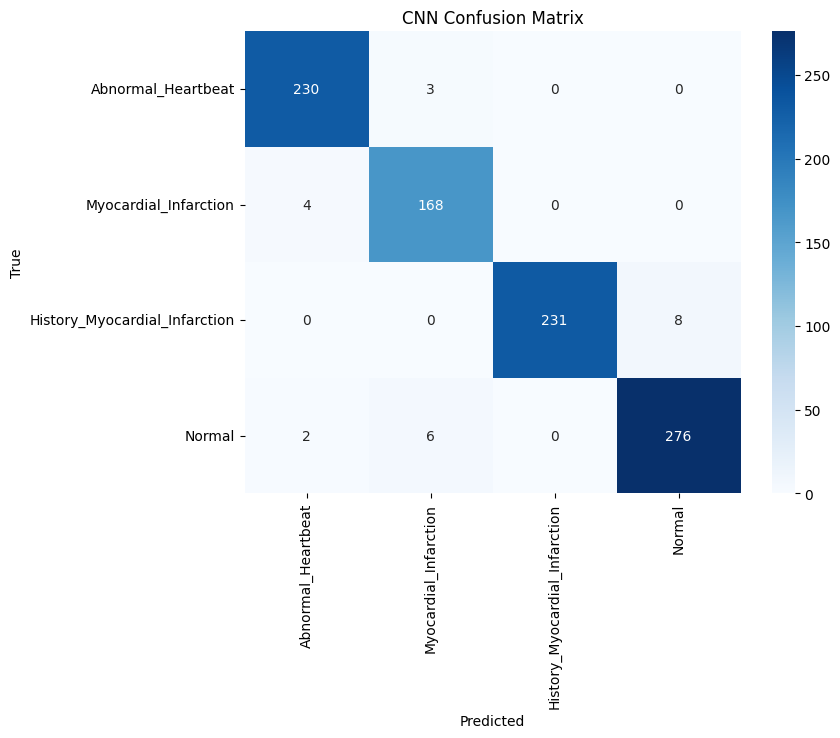

In [52]:
from tensorflow.keras.models import load_model

best_model = load_model("Small_2CNN_best.keras")


test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

# Confusion matrix
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=classes, yticklabels=classes,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()


In [53]:
model.save("../models/Small_2CNN.keras")

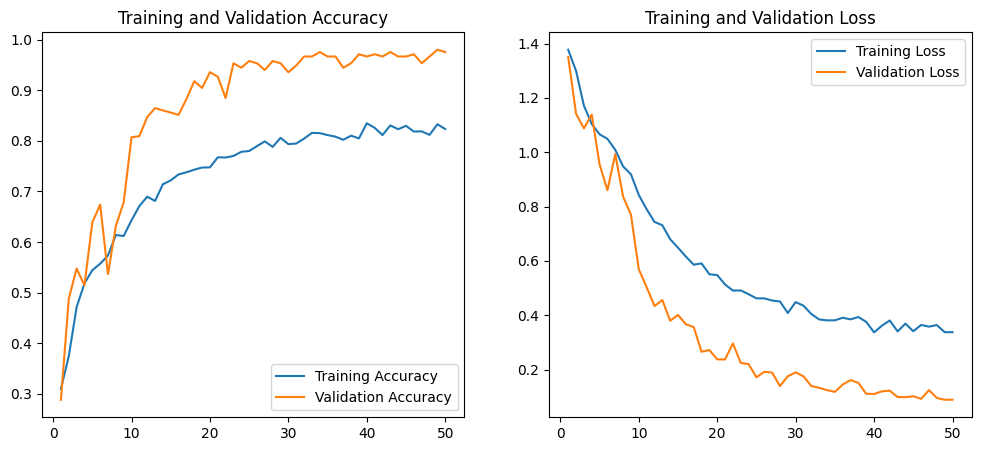

In [54]:
import matplotlib.pyplot as plt

# Extract history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

